# Defining the aoi

In [1]:
import pandas as pd
import numpy as np
import xarray as xa
from pathlib import Path
import src.data.ecostress_io as eio
import rioxarray
import sys
import geopandas as gpd
import json
import dask
from dask.distributed import Client

n_partitions = 8
root_path = Path("/mnt/ecostress/rhone-ecostress-data/")

with open(f"{root_path}/geo-countries/archive/countries.geojson", "rb") as f:
    all_countries_geojson = json.loads(f.read())


for i in all_countries_geojson['features']:
    if i['properties']['ADMIN'] == "France":
        france_geo = i


france_gdf = gpd.GeoDataFrame.from_features([france_geo]).explode()

france_gdf[france_gdf.area==max(france_gdf.area)].plot()

aoi = france_gdf[france_gdf.area==max(france_gdf.area)]

aoi_geojson = json.loads(aoi.to_json())

xmin, ymin, xmax, ymax = aoi.total_bounds
bounds_tuple = (4, 42, 7, 47)
xmin, ymin, xmax, ymax = bounds_tuple  # hardcoding since concattenating 1000s of ecostress files with different overlaps hangs

# Global rivers dataset

In [2]:
rivers_df = gpd.read_file(Path(root_path, "europe_rivers/eu_river.shp"))

rivers_df['R_ID'] = rivers_df['R_ID'].apply(int).apply(str)

france_rivers_df = rivers_df.cx[xmin:xmax, ymin:ymax]

aoi.crs = france_rivers_df.crs # setting crs for aoi

### Check to make sure they overlay, geopandas has poor support for linestrings so we subset by the bounding box

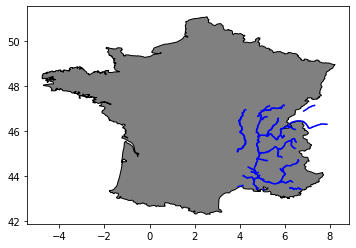

In [3]:
base = aoi.plot(color="grey", edgecolor="black")

france_rivers_df.plot(ax=base, color="blue")

## reading in paths and example data array

In [4]:
qa_path = Path(root_path, "ECO3ANCQA")
et_path = Path(root_path, "ECO3ETPTJPL")
esi_path = Path(root_path, "ECO4ESIPTJPL")

whole_tif_qa_paths, csv_qa_paths, xml_qa_paths = eio.separate_extensions(qa_path)

whole_tif_etdaily_paths, csv_et_paths, xml_et_paths = eio.separate_extensions(et_path, "*ETdaily*.tif")

Clipping all et tifs, takes about 10 min with threading. 

In [5]:
tempdir = Path("/home/ryan/work/tmp")

clipped_scene_paths = [Path(p) for p in tempdir.glob("*clipped*")]

if clipped_scene_paths == []:
    client = Client()
    
    batches = eio.batches_from(whole_tif_etdaily_paths, 8)
    
    batch_results = []
    
    for batch in batches:
    
        batch_result = dask.delayed(eio.clip_and_save)(batch, bounds_tuple, filter_nan = True, outDir=tempdir)
        batch_results.append(batch_result)
        
    result_futures = client.compute(batch_results, scheduler='processes')

    clipped_scene_paths = [i.result() for i in result_futures if i.result()]# gets rid of None that denotes too little scene overlap

    client.restart()
    

In [6]:
buffered_france_rivers_df = france_rivers_df.to_crs(epsg=2154)\
                                            .buffer(5000)\
                                            .to_crs(epsg=4326) # buffers by 5000 meters
france_rivers_df['geometry'] = buffered_france_rivers_df

/data/anaconda/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [7]:
resolution = eio.read_ecostress_scene(clipped_scene_paths[0]).rio.resolution()
crs = france_rivers_df.crs
aoi_grid = eio.gdf_to_dataarray(france_rivers_df, crs, resolution)

In [8]:
resampled_scene_paths = [Path(p) for p in tempdir.glob("*resampled*")]

if resampled_scene_paths == []:
    client = Client()
    batches = eio.batches_from(resampled_scene_paths, n_partitions)

    def wrapper(paths, aoi_grid, tempdir, path_id):
        return_paths = []
        for path in paths:
            x = eio.read_mask_ecostress_scene(path)
            y = eio.resample_xarray_to_basis(x, aoi_grid)
            return_paths.append(eio.write_tmp(y, tempdir, path_id))
        return return_paths

    all_results = []
    for batch in batches:
        sub_result = dask.delayed(wrapper)(batch, aoi_grid, tempdir, "resampled")
        all_results.append(sub_result)
        
    result_future = client.compute(all_results, scheduler="processes")
    
    resampled_scene_paths = [i.result() for i in result_future]
    
    client.restart()

In [12]:
resampled_data_arrays = eio.read_scenes(resampled_scene_paths)

In [25]:
et_tseries = xa.concat(resampled_data_arrays, dim="date").sortby('date')

In [27]:
from geocube.api.core import make_geocube
france_rivers_df['value'] = 1 # allow sus to make non empty dataset, required for resampling
river_arr = make_geocube(vector_data=france_rivers_df, resolution=resolution)['value']

/data/anaconda/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


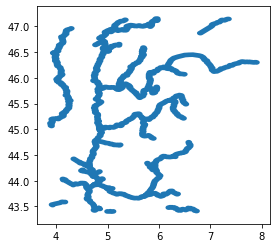

In [38]:
france_rivers_df.plot()

In [36]:
river_arr.where(river_arr==river_arr.attrs['_FillValue'], 0)

<xarray.DataArray 'value' (y: 6101, x: 6558)>
array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       ...,
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]])
Coordinates:
  * y            (y) float64 43.35 43.36 43.36 43.36 ... 47.19 47.2 47.2 47.2
  * x            (x) float64 7.957 7.956 7.956 7.955 ... 3.829 3.829 3.828 3.827
    spatial_ref  int64 0
Attributes:
    name:          value
    long_name:     value
    grid_mapping:  spatial_ref
    _FillValue:    -9999.0

In [26]:
et_tseries

<xarray.DataArray 'ECO3ETPTJPL001_EVAPOTRANSPIRATION_PT_JPL_ETdaily_doy2019240051431_aid0001-clipped-resampled.tif' (date: 101, band: 1, y: 6101, x: 6558)>
dask.array<getitem, shape=(101, 1, 6101, 6558), dtype=float32, chunksize=(1, 1, 6101, 6558), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 7.957 7.956 7.956 7.955 ... 3.829 3.829 3.828 3.827
  * band     (band) int64 1
  * y        (y) float64 43.35 43.36 43.36 43.36 43.36 ... 47.19 47.2 47.2 47.2
  * date     (date) datetime64[ns] 2018-07-29T17:12:56 ... 2019-10-16T09:41:20
Attributes:
    transform:      (-0.0006297774169670002, 0.0, 7.957237663378045, 0.0, 0.0...
    crs:            +init=epsg:4326
    res:            (-0.0006297774169670002, -0.0006297774169670006)
    is_tiled:       0
    nodatavals:     (-9999999999999.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

plotting data availability

In [ ]:
all_et_daily = eio.read_scenes(scene_paths)

# all_qa_paths = clip_and_save(whole_tif_qa_paths, bounds_tuple, filter_nan = True, outDir="/scratch/rave/tmp")
# all_qa_daily, all_et_daily = eio.match_da_lists(all_qa_daily, all_et_daily)

## ECOSTRESS Availability over the Rhone River
date_df = eio.get_date_df(all_et_daily)
# date_df.groupby([date_df['date'].dt.month, date_df['date'].dt.year]).count().plot(kind="bar")

In [ ]:
import matplotlib.pyplot as plt
from rasterio.enums import Resampling

possibly done did it. xarray plot plots intersect of minimum bound rect?

In [ ]:
import matplotlib.pyplot as plt
from rasterio.enums import Resampling

ax = plt.subplot()

r0 = all_et_daily[0].rio.reproject_match(cube['value'], resampling=Resampling.nearest)
r4 = all_et_daily[4].rio.reproject_match(cube['value'], resampling=Resampling.nearest)

r0.sel(band=1).plot.imshow(ax=ax, cmap="inferno")
r4.sel(band=1).plot.imshow(ax=ax, add_colorbar=False)


In [ ]:
r4.rio.to_raster("/scratch/rave/r4.tif")

In [ ]:
r0.sel(band=1).plot.imshow()

In [ ]:
r0.shape

In [ ]:
r4.shape

In [ ]:
all_et_daily[4].shape

In [ ]:
all_et_daily[0].shape

In [ ]:
ax = plt.subplot()
all_et_daily[0].sel(band=1).plot.imshow(ax=ax, cmap="inferno")
# et0.rio.reproject_match(et10).plot(ax=ax, add_colorbar=False)
# all_et_daily[4].sel(band=1).plot.imshow(ax=ax, add_colorbar=False)

Checking how well a contant lat lon resolution preserves distance/area rleationships over the aoi

https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude

trying xesmf takes a long time

In [ ]:
resolution = .0006349

In [ ]:
import geopy.distance

lonmin, latmin, lonmax, latmax = buffered_france_rivers_df.total_bounds
print("resolution distance at lower left", geopy.distance.geodesic((lonmin,latmin),(lonmin+resolution,latmin)).m)
print("resolution distance at upper right", geopy.distance.geodesic((lonmax,latmax),(lonmax,latmax+resolution)).m)

Need to make grid out and use xesmf to convert the grid ins

In [ ]:
buffered_france_rivers_df.unary_union.centroid

xesmf requires working with constant latitude and longitutde resolution.

In [ ]:
import xesmf as xe

grid_out = {"lon": np.arange(lonmin, lonmax, resolution),
           "lat": np.arange(latmin, latmax, resolution)}

In [ ]:
lon, lat = np.meshgrid(all_et_daily[0]['x'], all_et_daily[0]['y'])

In [ ]:
grid_in = {'lon': lon, 'lat': lat}


In [ ]:
help(xe.Regridder)

In [ ]:
regridder = xe.Regridder(grid_in, grid_out, method="bilinear")
regridder.clean_weight_file()
regridder


In [ ]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
%matplotlib inline

ETcolors = ["#f6e8c3", "#d8b365", "#99974a", "#53792d", "#6bdfd2", "#1839c5"]
ETcmap = LinearSegmentedColormap.from_list("ET", ETcolors)
date_utc = pd.to_datetime(et['date'].values)
layer_type = et.attrs['filename'].split("_")[-3]
title = 'ECO3ETPTJPL Evapotranspiration'

fig = plt.figure(figsize=(9.7,7.6))                                                       # Set the figure size (x,y)
fig.suptitle(f'{title} ({layer_type}) \n at {date_utc}', fontsize=22)  # Add title for the plots
plt.axis('off')                                                                           # Remove axes from plot
im = plt.imshow(et.sel(band=1), cmap=ETcmap);                                                        # Plot array using colormap
# plt.scatter(Tcol, Trow, color="black", marker='x')                                        # Plot tower location
# Add a colormap legend
plt.colorbar(im, orientation='horizontal', fraction=0.05, pad=0.004, label=f"ET ({et.attrs['units']})", shrink=0.6).outline.set_visible(True)

In [ ]:
xa.open_rasterio(tif_qa_paths[0], parse_coordinates=True)

## Code graveyard

trying to plot ecostress DataArray with geopandas shapes

In [ ]:
def cartopy_project_geo_df(df, crs):

    # This can be converted into a `proj4` string/dict compatible with GeoPandas
    crs_proj4 = crs.proj4_init
    return df.to_crs(crs_proj4)

crs = ccrs.PlateCarree()
aoi_projected = cartopy_project_geo_df(aoi, crs)
france_rivers_df_projected = cartopy_project_geo_df(france_rivers_df, crs)
# base = aoi_projected.plot(color="grey", edgecolor="black")
# france_rivers_df_projected.plot(ax=base, color="blue")


import cartopy.crs as ccrs
import matplotlib.pyplot as plt
ax = plt.axes(projection=crs)
all_et_daily[14].sel(band=1).plot.imshow(ax=ax, transform=crs)
# ax.add_geometries(aoi_projected['geometry'], crs=crs)
ax.add_geometries(france_rivers_df_projected['geometry'], crs=crs)

In [ ]:
def mask_NA_values():
    """
    Daily ET products have both nan values from where there are clouds 
    and -1e+13 for where the ecostress swath was clipped during the ordering process
    """
    masked_et = np.ma.masked_where(et.sel(band=1) == np.nan, et.sel(band=1))
    masked_et = np.ma.masked_where(masked_et == -1e+13, masked_et)